# Haar Compression Activity
stough 202-

DIP 6, 8.9

In this activity you're going to use the Haar wavelet block transform and lossy compression in two different contexts

- A single $4x4$ single-channel "image" block with fairly high contrast.
- A larger color image with $8x8$ blocks.

In each case we're going to 

- Transform: Turn a block of image pixels into a block of Haar wavelet coefficients. 
- Compress: We're going to effectively compress by zeroing out insigficant/small coefficients.
- Reconstruct: Take the "compressed" coefficent block and reconstruct the block of image pixels, with some loss.

Recall from [`view_basis_blocks`](./view_basis_blocks.ipynb) that the Haar $4x4$ transform matrix is like so:

\begin{equation*}
\mathbf{H_{Haar}} =  \frac{1}{2}\begin{vmatrix}
1 & 1 & 1 & 1\\
1 & 1 & -1 & -1 \\
{\sqrt 2} & -{\sqrt 2} & 0 & 0 \\
0 & 0 & {\sqrt 2} & -{\sqrt 2}
\end{vmatrix}
\end{equation*}

To transform a block of pixels $\mathbf{B}$ into a block of coefficients:

\begin{equation*}
\mathbf{T} = \mathbf{H}\times\mathbf{B}\times\mathbf{H}^T
\end{equation*}

where $\mathbf{H}^T$ is the transpose. Through the above we basically replace the set of independent pixels with the set of coefficients with respect to the Haar basis patterns, as we'll see with `vis_blocks`. Once we have $\mathbf{T}$, we can quantize it to the degree that we wish, zeroing out small coefficients, potentially replacing large coefficients with nearby approximations on a standard grade (e.g. replace anything in $[236,276]$ with $256$). 

To reconstruct the original $\mathbf{B}$, we can simply

\begin{equation*}
\mathbf{B} = \mathbf{H}^T\times\mathbf{T}\times\mathbf{H}
\end{equation*}

## Imports
We're going to use [`wavelet_utils`](../dip_utils/wavelet_utils.py).

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# For importing from alternative directory sources
import sys  
sys.path.insert(0, '../dip_utils')

from matrix_utils import (arr_info,
                          make_linmap)
from vis_utils import (vis_rgb_cube,
                       vis_hists,
                       vis_pair,
                       vis_surface)

from wavelet_utils import (make_haar_matrix,
                           make_random_basis,
                           make_klt_basis,
                           make_dct_matrix,
                           make_standard_matrix,
                           vis_blocks)

from skimage.util import view_as_blocks
from skimage.util import montage
from skimage.transform import resize, rescale

## 1. $4\times4$ Haar Wavelet Compression
Use `make_haar_matrix` and `vis_blocks` to see the 16 Haar patterns for the $\mathbf{H_{Haar}}$ matrix

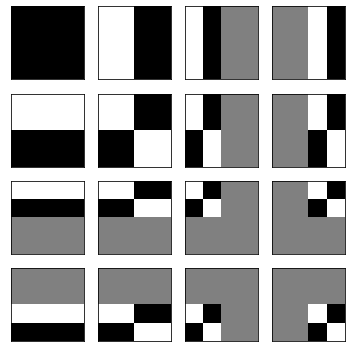

In [84]:
H = make_haar_matrix(4)
vis_blocks(H)

### Transform a $4\times4$ block of pixels.
We'll define the block of pixels in question. Then you transform it into the coefficient block $\mathbf{T}$. See [`np.matmul`](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html) to compute $\mathbf{H}\times\mathbf{B}\times\mathbf{H}^T$.

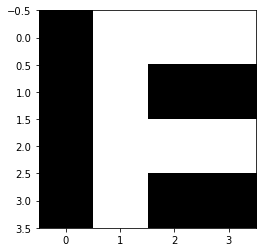

In [85]:
B = np.array([[0,1,1,1],
              [0,1,0,0],
              [0,1,1,1],
              [0,1,0,0]])

plt.figure(figsize=(4,4))
plt.imshow(B, cmap='gray')

In [86]:
T = np.matmul(H, np.matmul(B, H.T))

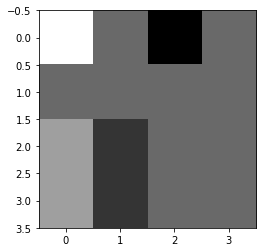

In [87]:
plt.figure(figsize=(4,4))
plt.imshow(T, cmap='gray')

### A. Viewing the transform coefficients in the matrix $\mathbf{T}$, what are the row and column coords for the two largest coefficients (in absolute value)?

- They are at (0, 0) and (0, 2).

### B. Show the two basis blocks corresponding to those two coefficients.

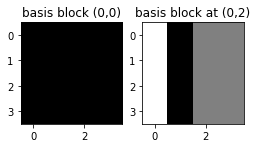

In [88]:
H00 = np.outer(H[0, :], H[0, :])
H02 = np.outer(H[0, :], H[2, :])
_, ax = plt.subplots(1, 2, figsize = (4,2))
ax[0].title.set_text('basis block (0,0)')
ax[1].title.set_text('basis block at (0,2)')
ax[0].imshow(H00, cmap='gray')
ax[1].imshow(H02, cmap='gray')

### C. Show and explain as explicitly as you can how the two coefficients are what they are.

- The basis block corresponding to the first coefficient is a block that takes average over the image. The first coefficient of 2 means that the average intensity of the original image is positive. <br>
The basis block corresponding to the second coefficient is a block that finds vertical edges in left half of the image. The second coefficient of -1.41 means that a vertical edge is found in the original image, but in the reverse direction of the edge in the basis block.

### D. Show the reconstruction of the image $\mathbf{B}$ using only those basis blocks/coefficients. 
Is this reconstruction trending in the right direction? Explain

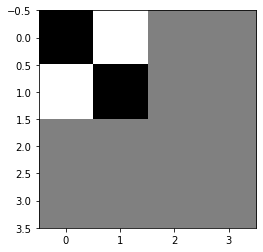

In [89]:
T00 = np.matmul(H00.T, T[0, 0]*H00) + np.matmul(H02.T, T[0, 2]*H02)
plt.figure(figsize=(4,4))
plt.imshow(T00, cmap='gray')

Yes. $\mathbf{B}=\mathbf{H}^T\times\mathbf{T}\times\mathbf{H}$. It's lossy and there are three (originally six) non-zero coefficients now.

## 2. Larger Image Block Transform and Reconstruction.
Use the code in [`block_viewing_demo`](./block_viewing_demo.ipynb) and [`basis_decomp_64pix.ipynb`](./basis_decomp_64pix.ipynb) to perform a similar transform/compress/reconstruct sequence on a larger image of your choice. 

- Use $8\times8$ blocks.
- Use [`resize`](https://scikit-image.org/docs/dev/api/skimage.transform.html?highlight=resize#skimage.transform.resize) on the image you choose to ensure that $8$ evenly divides it in height and width. This is for convenience: compression schemes have other mechanisms to deal with odd-shaped images, which we will ignore here.
- Perform reconstructions using the largest $[1,2,4,8,16]$ coefficients in absolute value per block. Note that keeping $16$ coefficients is equivalent to $\sim 3$x compression. 
- For at least the reconstructions using $[2,4]$, use `vis_pair` and zoom into an area to observe the effectiveness of the reconstruction on such limit basis (32x, 16x compression).  

You can **export this notebook** as a PDF to submit this work.

In [90]:
def reconstruct(n, H, out_shape, block_view):
    mod_block_view = np.zeros_like(block_view)
    for i, block in enumerate(block_view):
        CT = np.zeros(block.shape)
        newblock = np.zeros_like(block).astype('float64')
        for chan in range(3):
            CT[..., chan] = np.matmul(H, np.matmul(block[..., chan], H.T))
            B = CT[..., chan]
            S = np.sort(np.abs(B.ravel()))    # increasing order
            x = S[-n]    # nth largest coefficient
            Bz = B.copy()
            Bz[np.abs(B) < x] = 0
            CT[..., chan] = np.matmul(H.T, np.matmul(Bz, H))
        newblock = CT.copy().clip(0, 1)
        mod_block_view[i] = newblock
    mod_block_grid = montage(mod_block_view, grid_shape=out_shape, multichannel=True, padding_width=0, fill=[1,1,1])
    return mod_block_grid

In [91]:
I = plt.imread('../dip_pics/underwaterTree.png') # 1200x1200 pixels
I = I[...,:3] # cut out the alpha channel
H = make_haar_matrix(8)
block_shape = (8,8,3)
view = view_as_blocks(I, block_shape)
arr_info(view)

((150, 150, 1, 8, 8, 3), dtype('float32'), 0.043137256, 0.94509804)

In [92]:
block_view = np.reshape(view, [view.shape[0]*view.shape[1]] + list(block_shape))
arr_info(block_view)

((22500, 8, 8, 3), dtype('float32'), 0.043137256, 0.94509804)

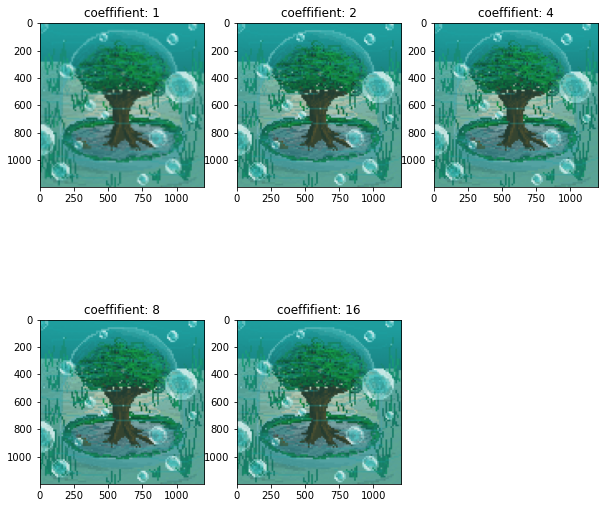

In [93]:
fig, axs = plt.subplots(2,3, figsize=(10,10))

mod_block_grid1 = reconstruct(1, H, view.shape[:2], block_view)
mod_block_grid2 = reconstruct(2, H, view.shape[:2], block_view)
mod_block_grid4 = reconstruct(4, H, view.shape[:2], block_view)
mod_block_grid8 = reconstruct(8, H, view.shape[:2], block_view)
mod_block_grid16 = reconstruct(16, H, view.shape[:2], block_view)

axs[0, 0].imshow(mod_block_grid1)
axs[0, 0].set_title('coeffifient: 1')
axs[0, 1].imshow(mod_block_grid2)
axs[0, 1].set_title('coeffifient: 2')
axs[0, 2].imshow(mod_block_grid4)
axs[0, 2].set_title('coeffifient: 4')
axs[1, 0].imshow(mod_block_grid8)
axs[1, 0].set_title('coeffifient: 8')
axs[1, 1].imshow(mod_block_grid16)
axs[1, 1].set_title('coeffifient: 16')
fig.delaxes(axs[1, 2])

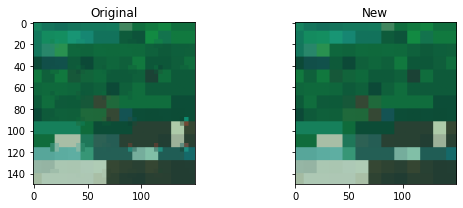

In [94]:
vis_pair(mod_block_grid2[400:550, 400:550], mod_block_grid4[400:550, 400:550])